In [1]:
from proj1_helpers import *
from implementations import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read train_y=LABELS, train_x=FEATURES and train_id=EVENT_IDS from dataset.
subsamp = True
y, x, id_ = load_csv_data('../data/train.csv', sub_sample=subsamp)
y_out_test, x_out_test, id_out_test = load_csv_data('../data/test.csv', sub_sample=subsamp)

In [3]:
clean=True
degree = 1
feature_expansion = False
x_train, y_train, x_test, y_test = split_data(x, y, ratio=0.7, seed = 42)
if clean:
    # Clean data
    y_train, x_train = clean_data(y_train, x_train)
    y_test, x_test = clean_data(y_test, x_test)
# Standardize data
x_train_std = standardize_features(x_train)
x_test_std = standardize_features(x_test)
x_train = x_train_std[0]
x_test = x_test_std[0]
# Build data matrix
tx_train = build_poly(x_train, degree)
tx_test = build_poly(x_test, degree)
tx_train.shape, tx_test.shape


((3500, 31), (1500, 31))

# Gradient Descent

In [ ]:
w_init = np.array([0] * tx_train.shape[1])
max_iter = 400
gamma = 0.0009
w_gd, loss_gd = least_squares_GD(y_train,
                                 tx_train,
                                 w_init,
                                 max_iter,
                                 gamma,
                                 pr=True,
                                 adapt_gamma=False,
                                 kind='mse',
                                accel=True)
gd_prediction = predict_labels(w_gd, tx_test)
acc_gd = accuracy_ratio(gd_prediction, y_test)
print('Accuracy ratio = %.3f' % acc_gd)
print('Test loss = %.3f' % compute_loss(y_test, tx_test, w_gd))
print('Train loss = %.3f' % loss_gd)

np.savetxt('../data/w_gd_acc.dat', w_gd)

# Stochastic Gradient Descent

In [ ]:
w_init = np.array([0] * tx_train.shape[1])
max_iter = 5000
gamma = 1e-4
batch_size = 1

w_sgd, loss_sgd = least_squares_SGD(y_train,
                                    tx_train,
                                    w_init,
                                    batch_size,
                                    max_iter,
                                    gamma,
                                    pr=True,
                                    adapt_gamma=False,
                                    choose_best=True)
sgd_prediction = predict_labels(w_sgd, tx_test)
acc_sgd = accuracy_ratio(sgd_prediction, y_test)
print('Accuracy ratio = %.2f' % acc_sgd)
print('Test loss = %.2e' % compute_loss(y_test, tx_test, w_sgd))
print('Train loss = %.2e' % loss_sgd)

# Least Squares

In [ ]:
w_lsq, loss_lsq = least_squares(y_train, tx_train)
lsq_prediction = predict_labels(w_lsq, tx_test)
acc_lsq = accuracy_ratio(lsq_prediction, y_test)
print('Accuracy ratio = %.2f' % acc_lsq)
print('Train loss = %.2f' % loss_lsq)
print('Test loss = %.2e' % compute_loss(y_test, tx_test, w_lsq))

np.savetxt('../data/w_lsq.dat', w_lsq)

# Ridge Regression

In [ ]:
lambda_ = 3.3e-2
w_rr, loss_rr = ridge_regression(y_train, tx_train, lambda_)
rr_prediction = predict_labels(w_rr, tx_test)
acc_rr = accuracy_ratio(rr_prediction, y_test)
print('Accuracy ratio = %.3f'%acc_rr)
print('Test loss = %.3f'%compute_loss(y_test, tx_test, w_rr))
print('Train loss = %.3f'%loss_rr)

np.savetxt('../data/w_rr.dat', w_rr)

In [ ]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 3, 50)
    # split the data, and return train and test data
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    #Clean
    if clean:
        y_train, x_train = clean_data(y_train, x_train)
        y_test, x_test = clean_data(y_test, x_test)
    # form train and test data with offset column
    x_train_std = standardize_features(x_train)[0]
    x_test_std = standardize_features(x_test)[0]
    tx_train=build_poly(x_train_std, degree)
    tx_test=build_poly(x_test_std, degree)
    rmse_tr = []
    rmse_te = []
    accuracies = []
    for ind, lambda_ in enumerate(lambdas):
        # calcualte weight through least square.
        w_train, loss_train = ridge_regression(y_train, tx_train, lambda_)
        rmse_tr.append(np.sqrt(2*loss_train))
        rmse_te.append(np.sqrt(2*compute_loss(y_test, tx_test, w_train, kind = 'mse')))
        accuracies.append(accuracy_ratio(predict_labels(w_train, tx_test), y_test))
        print("proportion={p}, degree={d}, lambda={l:.3e}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}, Accuracy={ac:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind], ac=accuracies[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    plt.figure()
    plt.semilogx(lambdas,accuracies, marker='o')
def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("../results/ridge_regression")

In [ ]:
seed = 42
degree = 2
split_ratio = 0.9
ridge_regression_demo(x, y, degree, split_ratio, seed)

In [4]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    id_test = k_indices[k]
    id_train = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
    x_test = x[id_test]
    x_train = x[id_train]
    y_test = y[id_test]
    y_train = y[id_train]
    #Clean
    #if clean:
    #    y_train, x_train = clean_data(y_train, x_train)
    #    y_test, x_test = clean_data(y_test, x_test)
    # Standardize
    x_train_std = standardize(x_train)[0]
    x_test_std = standardize(x_test)[0]
    # Define feature matrix
    tx_train = build_poly(x_train_std, degree)
    tx_test = build_poly(x_test_std, degree)
    # ridge regression
    weight, loss_tr = ridge_regression(y_train, tx_train, lambda_)
    # calculate the loss for train and test data
    loss_te = compute_loss(y_test, tx_test, weight)
    accuracy = accuracy_ratio(predict_labels(weight, tx_test), y_test)

    return loss_tr, loss_te, accuracy

Best lambda from accuracy: 2.59e-05
Best lambda from error: 1.27e-04


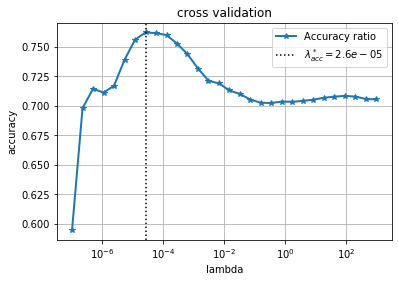

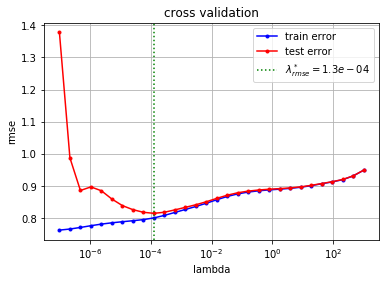

In [8]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    best_l_err = lambds[np.argmin(mse_te)]
    print('Best lambda from error: %.2e'%best_l_err)
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.axvline(best_l_err, c = 'g', label = '$\lambda^*_{rmse}=%.1e$'%best_l_err, ls = ':')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=0)
    plt.grid(True)
    plt.savefig("../results/cross_validation")
def cross_validation_visualization_accuracy(lambdas, accuracies):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambdas, accuracies, lw =2, marker = '*', label = 'Accuracy ratio')
    best_l_acc = lambdas[np.argmax(accuracies)]
    plt.axvline(best_l_acc, c= 'k', label = '$\lambda^*_{acc}=%.1e$'%best_l_acc, ls = ':')
    print('Best lambda from accuracy: %.2e'%best_l_acc)
    plt.xlabel("lambda")
    plt.ylabel("accuracy")
    plt.title("cross validation")
    plt.legend(loc=0)
    plt.grid(True)
    plt.savefig("../results/cross_validation_accuracies")
def cross_validation_demo():
    seed = 42
    degree = 4
    k_fold = 4
    lambdas = np.logspace(-7, 3, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    std_tr = []
    std_te = []
    accuracies = []
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        x_validation = np.array([cross_validation(y, x, k_indices, k, lambda_, degree) for k in range(k_fold)])
        rmse_tr.append(np.mean(np.sqrt(2 * x_validation[:, 0])))
        rmse_te.append(np.mean(np.sqrt(2 * x_validation[:, 1])))
        std_tr.append(np.std(np.sqrt(2 * x_validation[:, 0])))
        std_te.append(np.std(np.sqrt(2 * x_validation[:, 1])))
        accuracies.append(np.mean(x_validation[:,2]))
    cross_validation_visualization_accuracy(lambdas, accuracies)
    plt.figure()
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()


# Bias-Variance test

In [ ]:
def bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te):
    """visualize the bias variance decomposition."""
    rmse_tr_mean = np.expand_dims(np.mean(rmse_tr, axis=0), axis=0)
    rmse_te_mean = np.expand_dims(np.mean(rmse_te, axis=0), axis=0)
    print(rmse_te_mean, rmse_tr_mean)
    plt.plot(degrees,
             rmse_tr.T,
             'b',
             linestyle="-",
             color=([0.7, 0.7, 1]),
             label='train',
             linewidth=0.3)
    plt.plot(degrees,
             rmse_te.T,
             'r',
             linestyle="-",
             color=[1, 0.7, 0.7],
             label='test',
             linewidth=0.3)
    plt.plot(degrees,
             rmse_tr_mean.T,
             'b',
             linestyle="-",
             label='train',
             linewidth=3)
    plt.plot(degrees,
             rmse_te_mean.T,
             'r',
             linestyle="-",
             label='test',
             linewidth=3)
    plt.ylim(0.7, 1)
    plt.xlabel("degree")
    plt.ylabel("error")
    plt.title("Bias-Variance Decomposition")
    plt.savefig("bias_variance")


def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    ratio_train = 0.5
    degrees = range(1, 8)
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        # split data with a specific seed
        x_train, y_train, x_test, y_test = split_data(x, y, ratio_train, seed)
        x_train_std = standardize(x_train)[0]
        x_test_std = standardize(x_test)[0]
        for index_degrees, degree in enumerate(degrees):
            tx_train = build_poly(x_train_std, degree)
            tx_test = build_poly(x_test_std, degree)
            weight, loss_tr = ridge_regression(y_train, tx_train, 1.89e-05 )
            loss_te = compute_loss(y_test, tx_test, weight, kind='mse')
            rmse_tr[index_seed, index_degrees] = np.sqrt(2 * loss_tr)
            rmse_te[index_seed, index_degrees] = np.sqrt(2 * loss_te)
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)


bias_variance_demo()

In [ ]:
print(id_out_test.shape)
x_out_test_std = standardize_features(x_out_test)
x_out = x_out_test_std[0]
tx_out = build_poly(x_out, 2)

create_csv_submission(id_out_test, predict_labels(w_rr, tx_out) , '../results/rr_pred.csv')
create_csv_submission(id_out_test, predict_labels(w_gd, tx_out) , '../results/gd_pred_accel.csv')
create_csv_submission(id_out_test, predict_labels(w_lsq, tx_out) , '../results/lsq_pred.csv')
#create_csv_submission(id_out_test, predict_labels(w_sgd, tx_out) , '../results/sgd_pred_noadapt.csv')

# Logistic Regression

In [ ]:
def predict_labels_log(weights, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    y_pred[np.where(y_pred <= 0.5)] = -1
    y_pred[np.where(y_pred > 0.5)] = 1

    return y_pred

In [ ]:
y_train_log = np.copy(y_train)
y_train_log[y_train == -1] = 0

y_test_log = np.copy(y_test)
y_test_log[y_test == -1] = 0

w_init = np.array([0] * tx_train.shape[1])
max_iter = 10000
gamma = 1e-5
w_lrgd, loss_lrgd = logistic_regression(y_train_log,
                                        tx_train,
                                        w_init,
                                        max_iter,
                                        gamma,
                                        pr=True,
                                        adapt_gamma=False,
                                       accel=False)

lrgd_prediction = predict_labels_log(w_lrgd, tx_test)
print(tx_test.dot(w_lrgd))
acc_lrgd = accuracy_ratio(lrgd_prediction, y_test)

print('Accuracy ratio = %.3f' % acc_lrgd)
print('Test loss = %.3f' % compute_loss_logistic(y_test_log, tx_test, w_lrgd))
print('Train loss = %.3f' % loss_lrgd)

In [ ]:
lambda_ = 500
gamma = 1e-6
w_rlrgd, loss_rlrgd = reg_logistic_regression(y_train_log,
                                              tx_train,
                                              lambda_,
                                              w_init,
                                              max_iter,
                                              gamma,
                                              pr=True,
                                              adapt_gamma=False, 
                                              accel=False)
rlrgd_prediction = predict_labels_log(w_rlrgd, tx_test)
acc_rlrgd = accuracy_ratio(rlrgd_prediction, y_test)
print('Accuracy ratio = %.3f' % acc_rlrgd)
print('Test loss = %.3f' % compute_loss_logistic(y_test_log, tx_test, w_rlrgd))
print('Train loss = %.3f' % loss_rlrgd)

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    gamma = 1e-8
    # get k'th subgroup in test, others in train
    id_test = k_indices[k]
    id_train = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
    x_test = x[id_test]
    x_train = x[id_train]
    y_test = y[id_test]
    y_train = y[id_train]
    #Clean
    if clean:
        y_train, x_train = clean_data(y_train, x_train)
        y_test, x_test = clean_data(y_test, x_test)
    # Standardize
    x_train_std = standardize(x_train)[0]
    x_test_std = standardize(x_test)[0]
    # Define feature matrix
    tx_train = build_poly(x_train_std, degree)
    tx_test = build_poly(x_test_std, degree)
    y_train_log = np.copy(y_train)
    y_train_log[y_train == -1] = 0

    y_test_log = np.copy(y_test)
    y_test_log[y_test == -1] = 0
    # logistic regression
    weight, loss_tr = reg_logistic_regression(y_train_log,
                                              tx_train,
                                              lambda_,
                                              w_init,
                                              max_iter,
                                              gamma,
                                              pr=True,
                                              adapt_gamma=False)
    # calculate the loss for train and test data
    loss_te = compute_loss_logistic(y_test, tx_test, weight)
    accuracy = accuracy_ratio(predict_labels(weight, tx_test), y_test)

    return loss_tr, loss_te, accuracy

In [ ]:
cross_validation_demo()


# Logistic regression NEW

In [ ]:
w_init = np.zeros(tx_train.shape[1])
max_iter = 10000
gamma = 1e-5
w_lrgd, loss_lrgd = logistic_regression(y_train,
                                        tx_train,
                                        w_init,
                                        max_iter,
                                        gamma,
                                        pr=True,
                                        adapt_gamma=False,
                                       accel=False,
                                       new=True)

lrgd_prediction = predict_labels(w_lrgd, tx_test)

acc_lrgd = accuracy_ratio(lrgd_prediction, y_test)

print('Accuracy ratio = %.3f' % acc_lrgd)
print('Test loss = %.3f' % compute_loss_logistic_new(y_test, tx_test, w_lrgd))
print('Train loss = %.3f' % loss_lrgd)
print((w_lrgd))

In [ ]:
lambda_ = 100
gamma = 5e-6
w_rlrgd, loss_rlrgd = reg_logistic_regression(y_train,
                                              tx_train,
                                              lambda_,
                                              w_init,
                                              max_iter,
                                              gamma,
                                              pr=True,
                                              adapt_gamma=False, 
                                              accel=False,
                                              new = True)
rlrgd_prediction = predict_labels(w_rlrgd, tx_test)
acc_rlrgd = accuracy_ratio(rlrgd_prediction, y_test)
print('Accuracy ratio = %.3f' % acc_rlrgd)
print('Test loss = %.3f' % compute_loss_logistic_new(y_test, tx_test, w_rlrgd))
print('Train loss = %.3f' % loss_rlrgd)
print((w_rlrgd))

In [ ]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
  
    index = np.arange(k_indices.shape[0])
    index_te = k
    index_tr = index[index!=index_te]
    
    x_tr = x[np.ravel(k_indices[index_tr])]
    x_te = x[         k_indices[index_te]]
    y_tr = y[np.ravel(k_indices[index_tr])]
    y_te = y[         k_indices[index_te]]
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    
    weight, loss_tr = ridge_regression(y_tr, tx_tr, lambda_)
  
    loss_te = compute_loss(y_te, tx_te, weight)
    return loss_tr, loss_te, weight

def best_degree_lambda(y, x):
    """The entry."""
    # define parameters
    seeds = range(20)
    lambdas = np.logspace(-7, 0, 30)
    
    k_fold = 4
    ratio_train = 0.3
    degrees = range(1, 5)
    
    # define list to store the variable
    rmse_te = np.empty((len(seeds), len(degrees)))
    lambda_all = np.empty((len(seeds), len(degrees)))
    
    variance_te = np.empty(len(degrees))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        
        x_tr, y_tr, x_te, y_te = split_data(x, y, ratio_train, seed)
        #print(x_tr.shape)
        y_train, x_train = clean_data(y_tr, x_tr)
        #y_test, x_test = clean_data(y_test, x_test)
        
        x_tr_std = standardize_features(x_train)[0]
        x_te_std = standardize_features(x_te)[0]
        
        k_indices = build_k_indices(y_tr, k_fold, 1)
    
        for index_deg, deg in enumerate(degrees):
            tx_te = build_poly(x_te_std, deg)
            
            ws_lambda = []
            loss_te_lambda = np.empty(len(lambdas))
            
            for index_l, lambda_ in enumerate(lambdas):
                ws_k= []
                loss_te_k=np.empty(k_fold)
                
                for k in range(k_fold):
                    _, loss_te_tmp, w_tmp = cross_validation(y_tr, x_tr_std, k_indices, k, lambda_, deg)
                    loss_te_k[k] = loss_te_tmp
                    ws_k.append(w_tmp)
                    
                loss_te_lambda[index_l] = np.mean(loss_te_k)    
                ws_lambda.append(ws_k)
                
            ind_opt_lambda = np.argmin(loss_te_lambda)
            ws_opt = ws_lambda[ind_opt_lambda]
            
            loss_te = np.mean([np.sqrt(2*compute_loss(y_te, tx_te, w)) for w in ws_opt])             
            rmse_te[index_seed,index_deg] = loss_te 
            lambda_all[index_seed,index_deg] = lambdas[ind_opt_lambda]
            
    variance_te = np.std(rmse_te, axis=0)
    
    plt.figure(1)
    plt.errorbar(degrees, np.mean(rmse_te,axis=0), yerr=variance_te)
    plt.figure(2)
    plt.errorbar(degrees, np.mean(lambda_all,axis=0), yerr=np.std(lambda_all, axis=0))
    print(degrees[np.argmin(np.mean(rmse_te,axis=0))])
    return np.mean(rmse_te,axis=0), variance_te
    #plt.figure(2)
    #plt.boxplot(rmse_te)
    
    
         
rmse_CV, var_CV = best_degree_lambda(y, x)
